In [2]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Dataset

In [3]:
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

class FingerprintDataset(Dataset):
    def __init__(self,split):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt(f'./fingerprints/bace_fingerprints_reg_epi_{split}.csv', delimiter=',', dtype=np.float32, skiprows=1)

        self.x = torch.from_numpy(xy[:,1:])
        self.y = torch.from_numpy(xy[:,[0]])
        self.n_samples = xy.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [4]:
train_dataset = FingerprintDataset(split='train')
test_dataset = FingerprintDataset(split='test')

In [5]:
#Specify device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [6]:
import best_config

no_of_epochs = best_config.GLOBALPARAMETERS['no_of_epochs']
train_size = best_config.GLOBALPARAMETERS['train_size']
valid_size = best_config.GLOBALPARAMETERS['valid_size']

In [7]:
#Get Model Parameters
hyperparameters = eval('best_config.'+'MLP_DE'+'_HYPERPARAMETERS')

model_params = hyperparameters
model_params['feature_size'] = train_dataset.x.shape[1]

## Define Model

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
model_params

{'has_edge_info': False,
 'batch_size': 16,
 'learning_rate': 0.000933,
 'model_layers': 2,
 'model_embedding_size': 256,
 'model_dense_neurons': 64,
 'model_linear_dropout_rate': 0.0598,
 'model_embedding_dropout_rate': 0.0114,
 'no_of_models': 5,
 'feature_size': 1024}

In [10]:
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()  

NUM_FINGERPRINTS_PER_BATCH = model_params['batch_size']
train_loader = DataLoader(train_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, 
                    batch_size=NUM_FINGERPRINTS_PER_BATCH, shuffle=True)

## Training Loop

In [11]:
num_models = model_params['no_of_models']

import models
print("Loading model...")

#Create instance of model
deep_ensemble = []

for i in range(num_models):
    model = eval('models.'+best_config.GLOBALPARAMETERS['model_this_run']+'(model_params)')
    model.to(device)
    deep_ensemble.append(model)

Loading model...


In [12]:
optimizers = [torch.optim.Adam(m.parameters(), lr=model_params['learning_rate']) for m in deep_ensemble]

loss_fn = torch.nn.GaussianNLLLoss(eps=1e-02)

print("Starting training...")
for epoch in range(no_of_epochs):
    batch_loss = 0
    #train loop          
    for j, (fingerprint, labels) in enumerate(train_loader):
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        mus = []
        vars = []
        ensemble_loss = 0
        for i, model in enumerate(deep_ensemble):
            model.train()
            optimizers[i].zero_grad()
            mu, var = model(fingerprint)
            loss = loss_fn(mu, labels, var)
            ensemble_loss += loss.item()

            loss.backward()
            optimizers[i].step()
            
            mus.append(mu)
            vars.append(var)
        mean_ensemble_loss = ensemble_loss / len(deep_ensemble)
        batch_loss += mean_ensemble_loss
    train_loss = batch_loss / len(train_loader)
    '''
    #validation loop
    val_batch_loss = 0
    for j, (fingerprint, labels) in enumerate(valid_loader):
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        val_losses = []
        mus = []
        vars = []
        ensemble_loss = 0
        for i, model in enumerate(deep_ensemble):
            model = model.to(device)
            model.eval()
            mu, var = model(fingerprint)
            loss = loss_fn(mu, labels, var)
            ensemble_loss += loss.item()
            
            mus.append(mu)
            vars.append(var)
        mean_ensemble_loss = ensemble_loss / len(deep_ensemble)
        val_batch_loss += mean_ensemble_loss
    val_loss = val_batch_loss / len(valid_loader)'''



    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Train Loss {train_loss}")

Starting training...
Epoch 0 | Train Loss 4.724811135781444
Epoch 10 | Train Loss 0.35779501487697024
Epoch 20 | Train Loss 0.0728457707029424
Epoch 30 | Train Loss -0.06082208049483597
Epoch 40 | Train Loss -0.15814426399669373
Epoch 50 | Train Loss -0.20692661192366169
Epoch 60 | Train Loss -0.2525382684543729
Epoch 70 | Train Loss -0.30858376167322465
Epoch 80 | Train Loss -0.3391117286035105
Epoch 90 | Train Loss -0.355665484472717
Epoch 100 | Train Loss -0.3813647880660075
Epoch 110 | Train Loss -0.3934222064618216
Epoch 120 | Train Loss -0.4232038240830757
Epoch 130 | Train Loss -0.41331172210997663
Epoch 140 | Train Loss -0.46749984100461006
Epoch 150 | Train Loss -0.4527262987838567
Epoch 160 | Train Loss -0.4632832486574589
Epoch 170 | Train Loss -0.5263130939222481
Epoch 180 | Train Loss -0.523745711686972
Epoch 190 | Train Loss -0.5586024829235517


## Evaluate on the Test Set

In [13]:
df = pd.DataFrame({
      "y_pred": [],
      'y_real':[],
      'variance':[],
      })
model.eval()
with torch.no_grad():
    test_batch_loss = 0
    for fingerprint, labels in test_loader:
        fingerprint = fingerprint.to(device)
        labels = labels.to(device)
        test_losses = []
        mus = []
        vars = []
        ensemble_loss = 0
        for i, model in enumerate(deep_ensemble):
            model.eval()
            mu, var = model(fingerprint)
            loss = loss_fn(mu, labels, var)
            ensemble_loss += loss.item()            
            mus.append(mu)
            vars.append(var)
        mean_ensemble_loss = ensemble_loss / len(deep_ensemble)
        test_batch_loss += mean_ensemble_loss
        test_loss = test_batch_loss / len(test_loader)

        #For epistemic uncertainty we calculate the std on the mus!
        means = torch.stack(mus).mean(axis=0)
        stds = torch.stack(mus).std(axis=0)
        
        means = means.cpu()
        stds = stds.cpu()
        labels = labels.cpu()
        
        means = means.detach().numpy()
        stds = stds.detach().numpy()**(1/2)
        labels = labels.detach().numpy()
        
        y_vals = [labels, means, stds**2]
        data = {
            "y_pred": list(y_vals[0].squeeze()),
            'y_real': list(y_vals[1].squeeze()),
            "variance": list(y_vals[2].squeeze())
            }
        data = pd.DataFrame(data)
        df = df.append(pd.DataFrame(data))
df = df.sort_values('y_real').reset_index(drop=True)
df

,y_pred,y_real,variance
0,3.352617,3.826211,0.155310
1,3.603801,3.856649,0.203593
2,2.544546,3.901630,0.210650
3,3.370590,3.915434,0.211447
4,3.082494,3.974444,0.176841
...,...,...,...
298,8.161151,8.736588,0.175938
299,9.154902,9.044492,0.235949
300,8.698970,9.322044,0.376358
301,9.522879,11.335876,3.814221


array([[<AxesSubplot:title={'center':'variance'}>]], dtype=object)

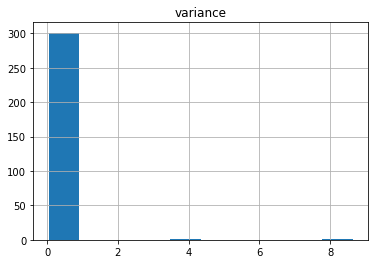

In [14]:
df.hist('variance')

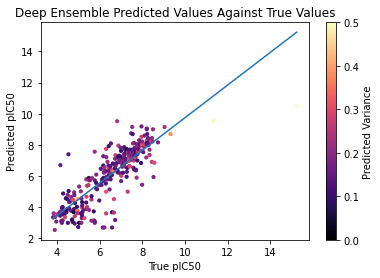

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data...
x = df["y_real"]
y = df["y_pred"]
color = df['variance']
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

sc = plt.scatter(x, y, c=color, s=10, cmap='magma')
cbar = plt.colorbar(sc)
cbar.set_label('Predicted Variance')
plt.xlabel('True pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Deep Ensemble')
plt.clim(0, 0.5) 
plt.title('Deep Ensemble Predicted Values Against True Values')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/pvtDE.jpeg', bbox_inches = 'tight', dpi=300)

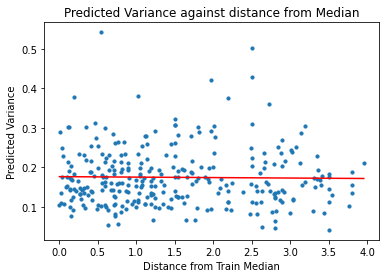

In [16]:
from scipy import stats
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

x = abs(df['y_pred']-6.5)
y = df['variance']

plt.scatter(x,y, s=10)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), c='r')
plt.xlabel('Distance from Train Median')
plt.ylabel('Predicted Variance')
plt.title('Predicted Variance against distance from Median')
plt.savefig('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/varvtDE.jpeg', bbox_inches = 'tight', dpi=300)

In [17]:
x = df.index
# Compute upper and lower bounds using chosen uncertainty measure: here
# it is a fraction of the standard deviation of measurements at each
# time point based on the unbiased sample variance
mu = df['y_pred']
lower = df['lower']
upper =  df['upper']

# Draw plot with error band and extra formatting to match seaborn style
fig, ax = plt.subplots(figsize=(9,5))
ax.scatter(x, df['y_real'], label='pred mean', s=1)
ax.plot(x, mu, label='pred mean')
ax.plot(x, lower, color='tab:blue', alpha=0.1)
ax.plot(x, upper, color='tab:blue', alpha=0.1)
ax.fill_between(x, lower, upper, alpha=0.2)
ax.set_xlabel('index')
ax.set_ylabel('pIC50')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

KeyError: 'lower'

## Model Evaluation

In [ ]:
from sklearn import metrics

In [ ]:
mse = metrics.mean_squared_error(df["y_real"],df["y_pred"])
mae = metrics.mean_absolute_error(df["y_real"],df["y_pred"])
r = metrics.r2_score(df["y_real"],df["y_pred"])

mse, mae, r

(0.923489660489072, 0.6890594879252798, 0.4247052725122282)

<AxesSubplot:xlabel='y_pred', ylabel='y_real'>

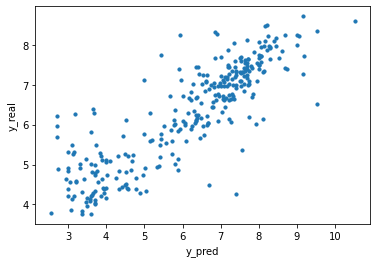

In [ ]:
df.plot.scatter(x='y_pred',y='y_real', s=10)

In [ ]:
rho = np.corrcoef(df['y_real'],df['y_pred'])[0,1]
rho

0.8569637856455015

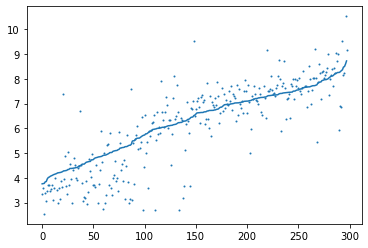

In [ ]:
import matplotlib.pyplot as plt

data_sorted_by_real = df.sort_values('y_real')
data_sorted_by_real = data_sorted_by_real.reset_index(drop = True)

plt.plot(data_sorted_by_real['y_real'].index, data_sorted_by_real['y_real'])
plt.scatter(data_sorted_by_real['y_real'].index, data_sorted_by_real['y_pred'], s=1)

In [ ]:
from sklearn import metrics
from scipy.stats import stats
df['y_pred_dist'] = abs(df['y_pred']-6.5)

def get_results(df):
    mse = metrics.mean_squared_error(df["y_real"],df["y_pred"])
    sc = stats.spearmanr(df["y_real"],df["y_pred"])[0]
    pc = np.corrcoef(df['y_real'],df['y_pred'])[0,1]
    r = metrics.r2_score(df["y_real"],df["y_pred"])
    varcorr = np.corrcoef(df['y_pred_dist'], df['variance'])[0,1]

    results = {
        'Mean Square Error':mse,
        'Spearman':sc,
        'Pearson':pc,
        'R':r,
        'Variance Rho': varcorr,
    }
    results_df = pd.DataFrame([results])
    return results_df

get_results(df).to_csv('/home/rajeckidoyle/Documents/Classification/BACE_Classification/regressionandunccertainty/results/DEresults.csv')
get_results(df)

,Mean Square Error,Spearman,Pearson,R,Variance Rho
0,0.92349,0.849173,0.856964,0.424705,-0.041876
